# Домашняя работа №5.

In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import researchpy as rp
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import ssl
from pylab import *

# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [2]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")

Данный датасет разобран в начале лекции 5. 

In [3]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
el_number_1 = len(data)
el_number_1

70000

### Сначала проверка на ошибки ###

In [5]:
# проверяем пустые значения
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Рекордное давление 310/220 (систолическое / дистолическое), все что выше - ошибочные данные

In [6]:
# систолическое давление, превышающее рекордное значение 
data[data.ap_hi > 310].shape

(39, 13)

In [7]:
# дистолическое давление, превышающее рекордное значение 
data[data.ap_lo > 220].shape

(953, 13)

In [8]:
# удаляем ошибочные значения
data = data.drop(data[data.ap_hi > 310].index)
data = data.drop(data[data.ap_lo > 220].index)
data = data.drop(data[data.ap_lo > data.ap_hi].index)

Проверяем рост и вес, удаляем экстремальные значения

Значения, выходящие за квартили, вес:

In [9]:
low = .05
high = .95
data.weight.quantile([low, high])

0.05     55.0
0.95    100.0
Name: weight, dtype: float64

Значения, выходящие за квартили, рост:

In [10]:
data.height.quantile([low, high])

0.05    152.0
0.95    178.0
Name: height, dtype: float64

Если делать выборку по квантилям модель получается менее точной, поэтому просто отсеиваем экстремальные значения.

In [11]:
# отсеиваем людей с недостатком и переизбытком соматропина, а также людей которые весят меньше 35 кг.
data = data.drop(data[data.height > 210].index)
data = data.drop(data[data.height < 147].index)
data = data.drop(data[data.weight < 35].index)

In [12]:
# отсеиваем по квантилям
#data = data.drop(data[data.weight < 55].index)
#data = data.drop(data[data.weight > 100].index)
#data = data.drop(data[data.height < 152].index)
#data = data.drop(data[data.height < 178].index)

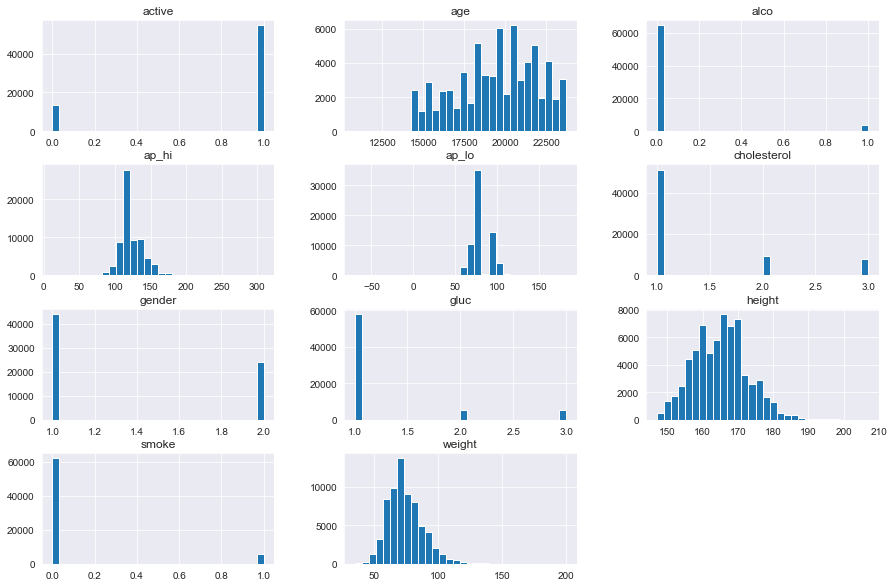

In [13]:
# Гистограммы для быстрой проверки, есть ли ошибочные значения в "бинарных" показателях
data.iloc[:,1:12].hist(figsize=(15,10), bins=30)
plt.show()

В бинарных показателях ошибок нет.

In [14]:
el_number_2 = len(data)
print('Удалено:', el_number_1 - el_number_2, 'строк')

Удалено: 1943 строк


Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn import preprocessing

In [16]:
output_y = data.iloc[:,12:]
input_x = data.iloc[:,1:12]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(input_x, output_y, test_size = 0.2, random_state = 42)

In [18]:
# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

No handles with labels found to put in legend.


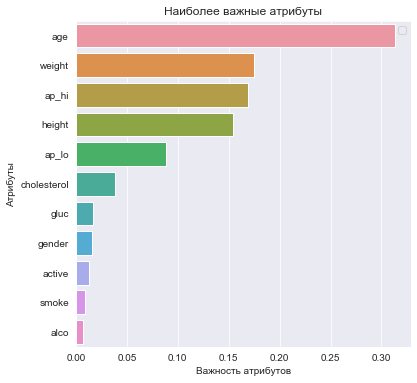

In [19]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [20]:
model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6850
           1       0.72      0.70      0.71      6762

    accuracy                           0.71     13612
   macro avg       0.71      0.71      0.71     13612
weighted avg       0.71      0.71      0.71     13612



0.7140758154569498

**Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.**

Наиболее значимым оказался фактор возраста, что ожидаемо.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима).
    Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

Два самых значимых атрибута - возраст и вес.

В первом случае, можно предположить, чем старше пациент, тем вероятнее больший риск сердечно-сосудистых заболеваний.

Во втором - чем больше вес, тем больше нагрузка на сердце и тем самым выше износ.

Интересно, что курение и алкоголь - на последнем месте. Стоит посмотреть, есть связь между этими параметрами и заболеваниями сердца.

**Возраст**

In [21]:
# разделим данные на выборки: старше и младше 40, старше и младше 55 лет

data_older_40 = data[data.age >= 14600]
data_under_40 = data[data.age < 14600]

data_older_55 = data[data.age >= 20075]
data_under_55 = data[data.age < 20075]

data_o40_u55 = data[ (data.age < 20075) & (data.age > 14600) ]

Множественный тест (ANOVA) также показывает различие трех возрастных групп

In [22]:
stats.f_oneway(data_under_40.cardio, data_o40_u55.cardio, data_older_55.cardio)

F_onewayResult(statistic=1495.714535807348, pvalue=0.0)

In [23]:
# сравним две группы, младше и старше 40 лет
descriptives, results = rp.ttest(data_under_40.cardio, data_older_40.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   1745.0  0.238968  0.426576  0.010212   0.218940  0.258997
1    cardio  66312.0  0.500890  0.500003  0.001942   0.497084  0.504695
2  combined  68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.2619
1            Degrees of freedom =   68055.0000
2                             t =     -21.6758
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.5257
7                     Hedge's g =      -0.5257
8                 Glass's delta =      -0.6140
9                             r =       0.0828


In [24]:
stats.ttest_ind(data_under_40.cardio, data_older_40.cardio)

Ttest_indResult(statistic=-21.675803831374587, pvalue=7.80806554329086e-104)

P-value меньше 0.05, т.е. можно отвергнуть гипотезу о сходстве выборок. Среднее значение у людей старше 40 - 0.50, у людей младше 0.24.

In [25]:
# все пациенты и старше 55 лет
descriptives, results = rp.ttest(data.cardio, data_older_55.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
1    cardio  30250.0  0.604727  0.488917  0.002811   0.599217  0.610237
2  combined  98307.0  0.528192  0.499207  0.001592   0.525072  0.531313
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1106
1            Degrees of freedom =   98305.0000
2                             t =     -32.2163
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.2226
7                     Hedge's g =      -0.2226
8                 Glass's delta =      -0.2211
9                             r =       0.1022


In [26]:
stats.ttest_ind(data.cardio, data_older_55.cardio)

Ttest_indResult(statistic=-32.216332588902326, pvalue=1.5913209572221331e-226)

Сравнивая любые группы, получаем p-value меньше 0,05, т.е. сравниваемые выборки имеют различия.

In [27]:
# пациенты младше и страше 55 лет
descriptives, results = rp.ttest(data_under_55.cardio, data_older_55.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  37807.0  0.405719  0.491037  0.002525   0.400769  0.410668
1    cardio  30250.0  0.604727  0.488917  0.002811   0.599217  0.610237
2  combined  68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1990
1            Degrees of freedom =   68055.0000
2                             t =     -52.6385
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.4061
7                     Hedge's g =      -0.4061
8                 Glass's delta =      -0.4053
9                             r =       0.1978


**Курение**

Показатель smoke - это просто отметка курит ли пациент в данный момент или нет, т.е. не учитывается стаж курения, курил пациент раньше или нет (он мог курить 40 лет, а потом бросить).

Сравним две группы людей старше 55 лет: тех, кто курит и тех, кто не курит.

In [28]:
data_smoke = data[data.smoke == 1].cardio
data_nosmoke = data[data.smoke == 0].cardio

data_under_40_smoke = data_under_40[data_under_40.smoke == 1].cardio
data_under_40_nosmoke = data_under_40[data_under_40.smoke == 0].cardio

data_older_40_smoke = data_older_40[data_older_40.smoke == 1].cardio
data_older_40_nosmoke = data_older_40[data_older_40.smoke == 0].cardio

data_older_55_smoke = data_older_55[data_older_55.smoke == 1].cardio
data_older_55_nosmoke = data_older_55[data_older_55.smoke == 0].cardio

data_under_55_smoke = data_under_55[data_under_55.smoke == 1].cardio
data_under_55_nosmoke = data_under_55[data_under_55.smoke == 0].cardio

In [29]:
# курящие и некурящие младше 40

descriptives, results = rp.ttest(data_under_40_nosmoke, data_under_40_smoke)
print(descriptives)
print('_____________________________')
print(results)

   Variable       N      Mean        SD        SE  95% Conf.  Interval
0    cardio  1557.0  0.238921  0.426561  0.010810   0.217717  0.260125
1    cardio   188.0  0.239362  0.427833  0.031203   0.177807  0.300917
2  combined  1745.0  0.238968  0.426576  0.010212   0.218940  0.258997
_____________________________
                Independent t-test    results
0  Difference (cardio - cardio) =     -0.0004
1            Degrees of freedom =   1743.0000
2                             t =     -0.0134
3         Two side test p value =      0.9893
4        Difference < 0 p value =      0.4947
5        Difference > 0 p value =      0.5053
6                     Cohen's d =     -0.0010
7                     Hedge's g =     -0.0010
8                 Glass's delta =     -0.0010
9                             r =      0.0003


In [30]:
stats.ttest_ind(data_under_40_smoke, data_under_40_nosmoke)

Ttest_indResult(statistic=0.013376673603450106, pvalue=0.989328807816468)

В выборках до 40 - p-value больше 0.05, т.е. мы не можем отвергнуть гипотезу о значимых различиях, плюс средние значения почти одинаковы.

Однако, сравнивая выборки пациентов старше 40 и старше 55, мы получаем p-value - 0.0001 и 0.0027, соответственно.
Раз значения меньше альфы, можно говорить о статистических различиях.

In [31]:
# курящие и некурящие страше 40

descriptives, results = rp.ttest(data_older_40_nosmoke, data_older_40_smoke)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  60475.0  0.503299  0.499993  0.002033   0.499314  0.507284
1    cardio   5837.0  0.475929  0.499463  0.006537   0.463114  0.488745
2  combined  66312.0  0.500890  0.500003  0.001942   0.497084  0.504695
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.0274
1            Degrees of freedom =   66310.0000
2                             t =       3.9942
3         Two side test p value =       0.0001
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.0547
7                     Hedge's g =       0.0547
8                 Glass's delta =       0.0547
9                             r =       0.0155


In [32]:
# курящие и некурящие страше 55

descriptives, results = rp.ttest(data_older_55_nosmoke, data_older_55_smoke)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  27920.0  0.607163  0.488390  0.002923   0.601434  0.612892
1    cardio   2330.0  0.575536  0.494367  0.010242   0.555453  0.595620
2  combined  30250.0  0.604727  0.488917  0.002811   0.599217  0.610237
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.0316
1            Degrees of freedom =   30248.0000
2                             t =       3.0002
3         Two side test p value =       0.0027
4        Difference < 0 p value =       0.9986
5        Difference > 0 p value =       0.0014
6                     Cohen's d =       0.0647
7                     Hedge's g =       0.0647
8                 Glass's delta =       0.0648
9                             r =       0.0172


**Алкоголь**

Показатель alco - также субъективен и не описывает, есть ли у пациента серьезная зависимость или он умеренно пьет время от времени.

In [33]:
data_alco = data[data.alco == 1].cardio
data_noalco = data[data.alco == 0].cardio

data_older_40_alco = data_older_40[data_older_40.alco == 1].cardio
data_older_40_noalco = data_older_40[data_older_40.alco == 0].cardio

data_older_55_alco = data_older_55[data_older_55.alco == 1].cardio
data_older_55_noalco = data_older_55[data_older_55.alco == 0].cardio

Сначала сравним 2 группы: тех, кто пьет, и тех, кто не пьет:

In [34]:
descriptives, results = rp.ttest(data_alco, data_noalco)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   3647.0  0.476556  0.499519  0.008271   0.460339  0.492773
1    cardio  64410.0  0.495172  0.499981  0.001970   0.491310  0.499033
2  combined  68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0186
1            Degrees of freedom =   68055.0000
2                             t =      -2.1875
3         Two side test p value =       0.0287
4        Difference < 0 p value =       0.0144
5        Difference > 0 p value =       0.9856
6                     Cohen's d =      -0.0372
7                     Hedge's g =      -0.0372
8                 Glass's delta =      -0.0373
9                             r =       0.0084


Хотя p-value = 0.028, группы статистически различны. Средние значения близки, у тех, кто пьет, даже чуть лучше.

Однако сравнения возрастных групп показывают другие результаты:

In [35]:
# пациенты после 40

descriptives, results = rp.ttest(data_older_40_alco, data_older_40_noalco)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   3520.0  0.486648  0.499893  0.008426   0.470128  0.503167
1    cardio  62792.0  0.501688  0.500001  0.001995   0.497777  0.505599
2  combined  66312.0  0.500890  0.500003  0.001942   0.497084  0.504695
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0150
1            Degrees of freedom =   66310.0000
2                             t =      -1.7367
3         Two side test p value =       0.0824
4        Difference < 0 p value =       0.0412
5        Difference > 0 p value =       0.9588
6                     Cohen's d =      -0.0301
7                     Hedge's g =      -0.0301
8                 Glass's delta =      -0.0301
9                             r =       0.0067


In [36]:
# пациенты после 55

descriptives, results = rp.ttest(data_older_55_alco, data_older_55_noalco)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   1460.0  0.586301  0.492665  0.012894   0.561009  0.611593
1    cardio  28790.0  0.605662  0.488717  0.002880   0.600016  0.611307
2  combined  30250.0  0.604727  0.488917  0.002811   0.599217  0.610237
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0194
1            Degrees of freedom =   30248.0000
2                             t =      -1.4761
3         Two side test p value =       0.1399
4        Difference < 0 p value =       0.0700
5        Difference > 0 p value =       0.9300
6                     Cohen's d =      -0.0396
7                     Hedge's g =      -0.0396
8                 Glass's delta =      -0.0393
9                             r =       0.0085


P-value больше 0.05 в обоих сравнениях, среднее значение у "пьющих" даже ниже. 

Возможны, два варианта:
* Употребление алкоголь и сердечно-сосудистые заболевания не так сильно связаны, как могло кажется.
* Датасет не позволяет объективно и полно оченить эту связь. Мы знаем только пьет или не пьет пациент на данный момент, но  не знаем в каких количествах, пил ли раньше, есть ли у него зависимость.

**Вес**

RandomForest показывает влияние веса и роста на сердечно-сосудистые заболевания.

Чтобы оценить влияние, воспользуемся метрикой "Индекс массы тела", которая рассчитывается по формуле: BMI = $\frac{m}{h^{2}}$

In [37]:
def count_BMI(row):
    BMI = round(row.weight / ((row.height/100) ** 2), 0)
    return BMI   

In [38]:
data['BMI'] = data.apply(count_BMI, axis=1)

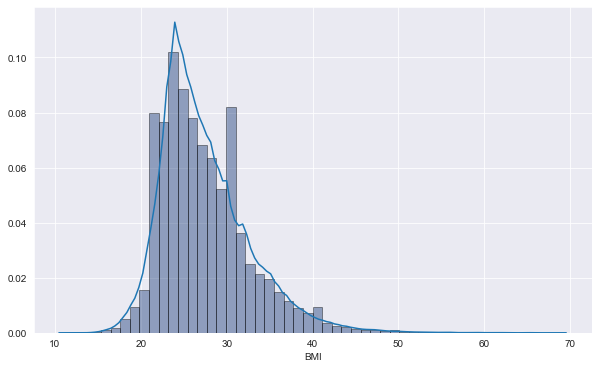

In [39]:
rcParams['figure.figsize'] = 10,6
sns.distplot(
    data.BMI, bins=50, kde=True,
    hist_kws={'color':'#052A6E', 'edgecolor':'k', 'linewidth':'1'}    
)
plt.show()

In [40]:
underweight = data[data.BMI < 18] # ниже нормы 
normal_weight = data[ (data.BMI >= 18) & (data.BMI < 25)] # норма 
overweight = data[data.BMI > 25] # выше нормы
overweight_2 = data[data.BMI > 35] # ожирение

Сравним выборки пациентов с нормальным весом и с избыточным:

In [41]:
# пациенты с нормальным и с избыточным весом

descriptives, results = rp.ttest(normal_weight.cardio, overweight.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  21979.0  0.387643  0.487223  0.003286   0.381201  0.394084
1    cardio  39091.0  0.562406  0.496097  0.002509   0.557488  0.567324
2  combined  61070.0  0.499509  0.500004  0.002023   0.495543  0.503474
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1748
1            Degrees of freedom =   61068.0000
2                             t =     -42.0533
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.3545
7                     Hedge's g =      -0.3545
8                 Glass's delta =      -0.3587
9                             r =       0.1678


P-value меньше 0.05, среднее пациентов с нормальным весом значительно меньше.

Сравним выборки по всем пациентам и пациентам с избыточным весом и ожирением:

In [42]:
# все пациенты и пациенты с избыточным весом

descriptives, results = rp.ttest(data.cardio, overweight.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable         N      Mean        SD        SE  95% Conf.  Interval
0    cardio   68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
1    cardio   39091.0  0.562406  0.496097  0.002509   0.557488  0.567324
2  combined  107148.0  0.519067  0.499639  0.001526   0.516075  0.522059
_____________________________
                Independent t-test      results
0  Difference (cardio - cardio) =       -0.0682
1            Degrees of freedom =   107146.0000
2                             t =      -21.5651
3         Two side test p value =        0.0000
4        Difference < 0 p value =        0.0000
5        Difference > 0 p value =        1.0000
6                     Cohen's d =       -0.1369
7                     Hedge's g =       -0.1369
8                 Glass's delta =       -0.1365
9                             r =        0.0657


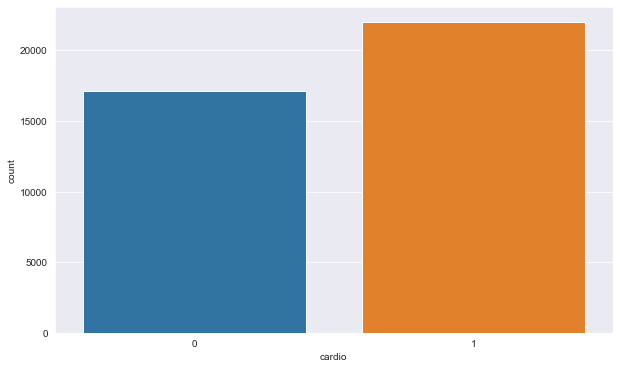

In [43]:
sns.countplot(x='cardio', data=overweight)

In [44]:
# все пациенты и пациенты с ожирением

descriptives, results = rp.ttest(data.cardio, overweight_2.cardio)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  68057.0  0.494174  0.499970  0.001916   0.490418  0.497930
1    cardio   5074.0  0.678754  0.467001  0.006556   0.665902  0.691607
2  combined  73131.0  0.506981  0.499955  0.001849   0.503357  0.510604
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1846
1            Degrees of freedom =   73129.0000
2                             t =     -25.4819
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.3708
7                     Hedge's g =      -0.3708
8                 Glass's delta =      -0.3692
9                             r =       0.0938


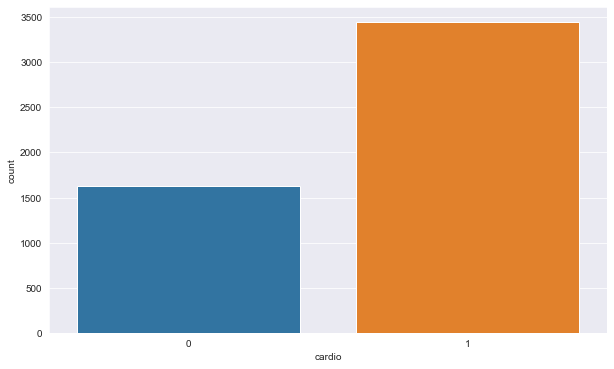

In [45]:
sns.countplot(x='cardio', data=overweight_2)

На последнем примере особенно очевидна связь избыточного веса и сердечно-сосудистых заболеваний.

## Выводы ##

1) Чем старше человек, тем выше риск заболеваний сердца.

2) Избыточный вес и, особенно, ожирение значительно повышают риск заболеваний

3) Датасет не позволяет объективно оценить связь курение и употребления алкоголя с сердечно-сосудистыми болезнями.